In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports
import sys
import os
import json

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap
from IPython.display import display

# Matplotlib utilities
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set pandas display options
pd.set_option("display.max_rows", 200)

# Define file location
PY_FILE_LOC = os.getcwd()

# Project-specific utility imports
from utils.japan_admin_data import (
    prefecture_dict_jp_to_en,
    japanadmin_muni_all_jp_to_en,
)

from utils.nbutils_load_data import (
    load_and_process_data,
    build_df_for_analysis,
    get_scale_param,
)
from utils.nbutils_cluster_stats import (
    align_spacing,
    format_mean_std,
    get_pref_muni_isin,
    get_cluster_actual_stats,
)
from utils.nbutils_corr import vars_iv_rename_cols
from utils.savefig import savefig_template
from utils.nbutils_shap import plot_feature_importance_base

# Modeling imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

/home/matthew/GitHub/japan-data/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load the config
config_fn = os.path.join(PY_FILE_LOC, "config.json")
if os.path.exists(config_fn):
    with open(config_fn) as config_file:
        config = json.load(config_file)
else:
    config = dict()

SAVE_FLAG = bool(config.get("save_figure"))
FIG_BASE_FOLDER = os.path.join(PY_FILE_LOC, "fig")
if not os.path.exists(FIG_BASE_FOLDER):
    os.mkdir(FIG_BASE_FOLDER)

def savefig(fig, fn, **kwargs):
    return savefig_template(SAVE_FLAG, FIG_BASE_FOLDER, fig, fn, **kwargs)

In [4]:
ftr_pref_muni = ["pref", "muni"]
ftr_year_pref_muni = ["year", "pref", "muni"]
pv_types = ["PV_R", "PV_S"]
folder = os.path.join(PY_FILE_LOC, "data")
pv_params, df = load_and_process_data(folder)

pv_cols = dict()
for pv_type in pv_types:
    pv_cols[pv_type] = pv_params.filter(regex=f"^{pv_type}").columns.tolist()

scale_param = get_scale_param()

print(pv_params.filter(regex="^land_").sum().div(1_000_000))
print(pv_params.columns)
print(df.columns)

land_total        37.295617
land_habitable    12.293681
land_buildings     1.746126
land_agri          4.325727
land_avail         6.221828
dtype: float64
Index(['pref', 'muni', 'demand', 'land_total', 'land_habitable',
       'land_buildings', 'land_agri', 'taxable_income', 'LV', 'LV_2014',
       'LV_2015', 'LV_2016', 'LV_2017', 'LV_2018', 'LV_2019', 'LV_2020',
       'LV_2021', 'LV_2022', 'LV_2023', 'PV_R_2014', 'PV_R_2015', 'PV_R_2016',
       'PV_R_2017', 'PV_R_2018', 'PV_R_2019', 'PV_R_2020', 'PV_R_2021',
       'PV_R_2022', 'PV_R_2023', 'PV_S_2014', 'PV_S_2015', 'PV_S_2016',
       'PV_S_2017', 'PV_S_2018', 'PV_S_2019', 'PV_S_2020', 'PV_S_2021',
       'PV_S_2022', 'PV_S_2023', 'PV_M_2014', 'PV_M_2015', 'PV_M_2016',
       'PV_M_2017', 'PV_M_2018', 'PV_M_2019', 'PV_M_2020', 'PV_M_2021',
       'PV_M_2022', 'PV_M_2023', 'PV_U_2014', 'PV_U_2015', 'PV_U_2016',
       'PV_U_2017', 'PV_U_2018', 'PV_U_2019', 'PV_U_2020', 'PV_U_2021',
       'PV_U_2022', 'PV_U_2023', 'pv_out', 'epco', 

## PV Type Specific

Do not change vars_dv from this point onwards

In [5]:
vars_dv = "PV_R"
no_outlier = True

In [6]:
# focus on the no outlier
if no_outlier:
	outlier_filename = os.path.join(PY_FILE_LOC, "data", "pv_growth_outlier.csv")
	outlier_summary = pd.read_csv(outlier_filename)
	outlier_index = outlier_summary[ftr_pref_muni].apply(tuple, axis=1).to_list()

	pv_param_no_outliers = pv_params[
        ~(pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(outlier_index))
    ]
	pv_param_outliers = pv_params[
        (pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(outlier_index))
    ]
	df = build_df_for_analysis(pv_param_no_outliers)

len(df)

17080

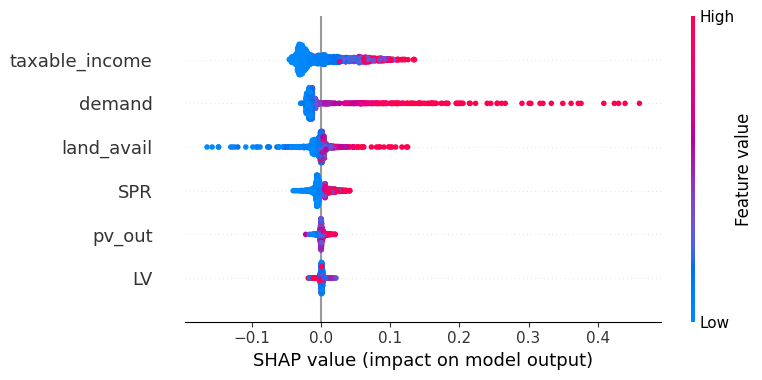

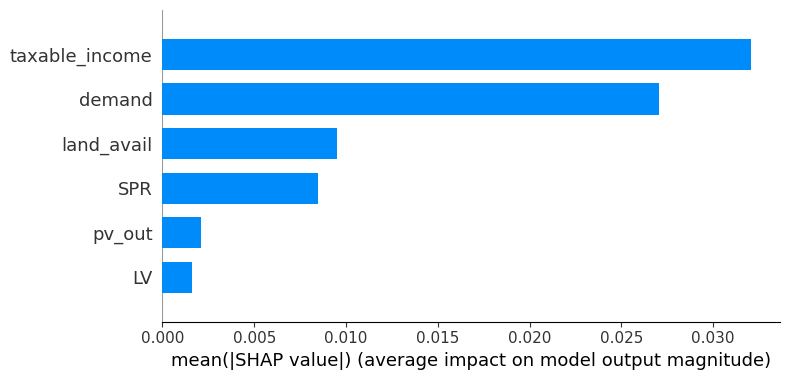

r2: 0.984253097516284
Normalized SHAP Feature Importance
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.027032    0.009505        0.032041  0.001590  0.008475  0.002083
%         0.334857    0.117748        0.396901  0.019696  0.104990  0.025809


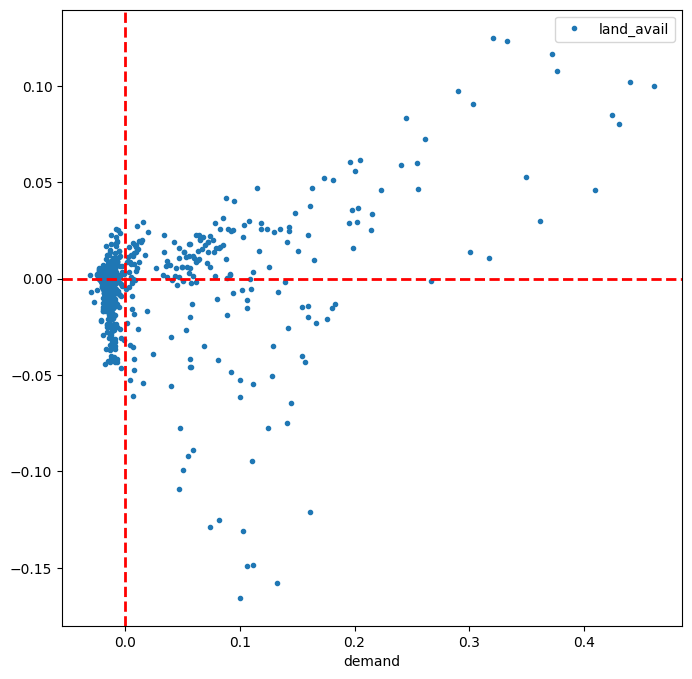

In [7]:
def plot_feature_importance(year):
	return plot_feature_importance_base(df, vars_dv, year)

plot_feature_importance(year=2015)

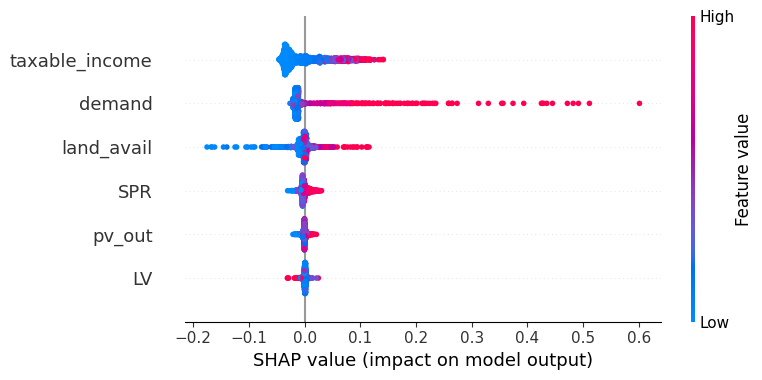

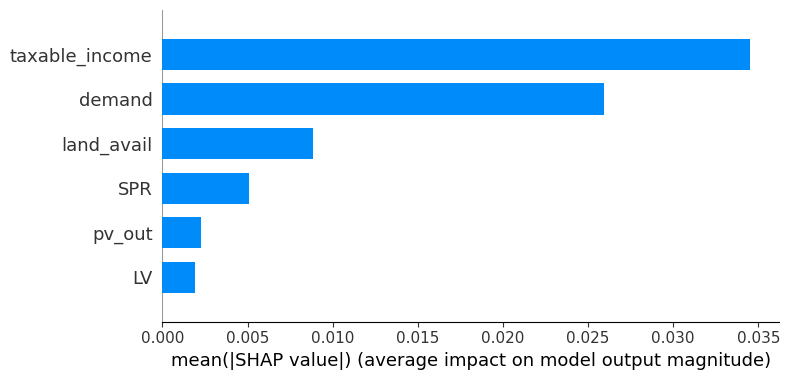

r2: 0.9853595413358266
Normalized SHAP Feature Importance
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.025945    0.008862        0.034512  0.001914  0.005060  0.002254
%         0.330318    0.112828        0.439377  0.024364  0.064419  0.028694


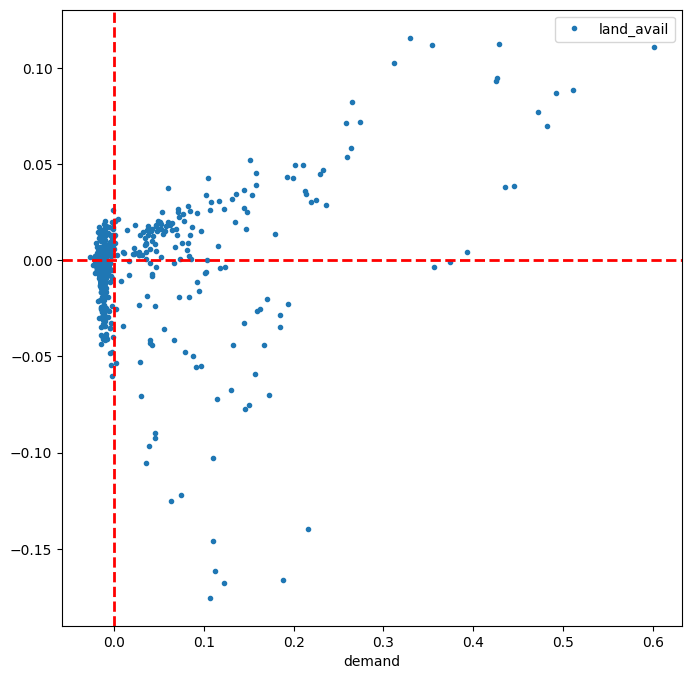

In [8]:
plot_feature_importance(year=2023)

## SHAP Calculations

In [9]:
# ============================================================================ #
# Train
# ============================================================================ #

# select the dependent and independent variables
vars_iv = ["demand", "land_avail", "taxable_income", "LV", "SPR", "pv_out"]

X = df[vars_iv]
y = df[vars_dv]

# train with 40% of the 10-year data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6, random_state=42
)

# Train the model
model = RandomForestRegressor(random_state=42, n_jobs=16)
model.fit(X_train, y_train)

# calculate the scores
regre_stats = dict()
y_pred = model.predict(X_test)
regre_stats["r2"] = r2_score(y_test, y_pred)
regre_stats["mae"] = mean_absolute_error(y_test, y_pred)
regre_stats["mse"] = mean_squared_error(y_test, y_pred)
regre_stats["rmse"] = np.sqrt(regre_stats["mse"])
print(regre_stats)

# save the model
model_loc = os.path.join(PY_FILE_LOC, "data", f'model_RFR_{vars_dv}.joblib')
joblib.dump(model, model_loc, compress=3)

{'r2': 0.9909573997888543, 'mae': 0.003991354639715241, 'mse': 8.477175815879224e-05, 'rmse': 0.009207157984893723}


['/home/matthew/GitHub/japan-data/notebook/eds-jp-pv-growth-resi-small/data/model_RFR_PV_R.joblib']

In [104]:
# ============================================================================ #
# Predict and calculate the SHAP values
# ============================================================================ #
year = 2023

df_temp = df[df["year"] == year]

X_sample = df_temp[vars_iv]
y_sample = df_temp[vars_dv]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Predict and calculate residuals
predictions = model.predict(X_sample)
residuals = y_sample - predictions

print("R²", r2_score(predictions, y_sample))

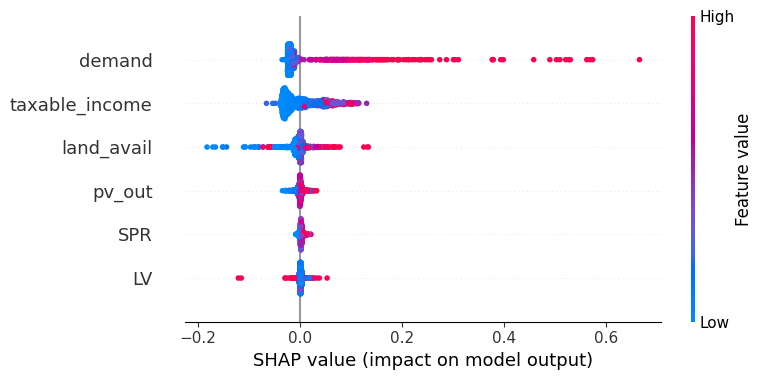

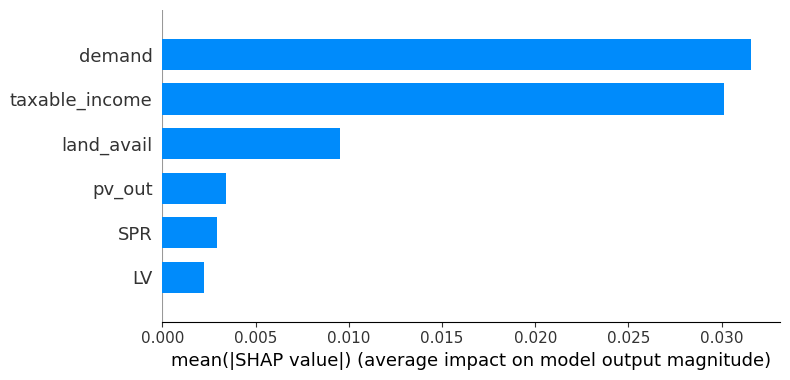

r2: 0.994145910367987
            demand  land_avail  taxable_income        LV       SPR    pv_out
mean_abs  0.031552    0.009523        0.030110  0.002243  0.002933  0.003422
%         0.395475    0.119366        0.377402  0.028111  0.036760  0.042886


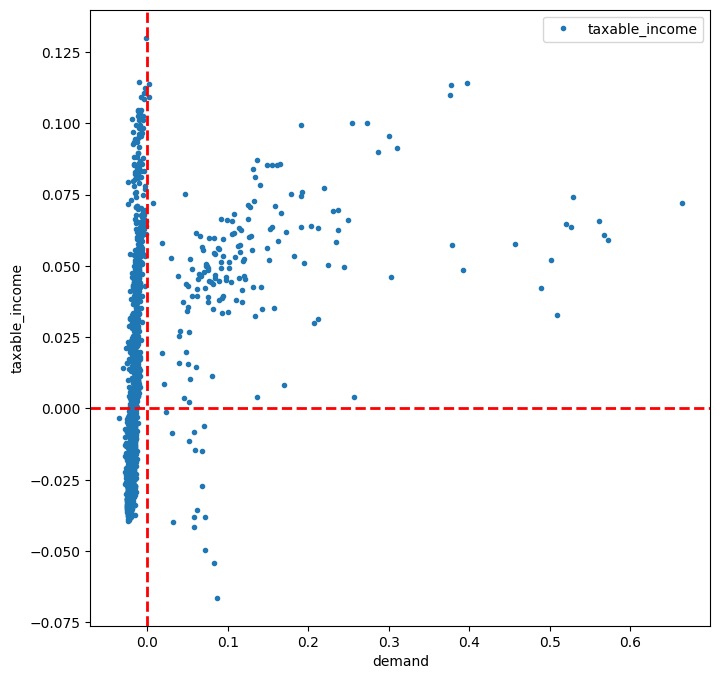

In [11]:
# ============================================================================ #
# PLOTS
# ============================================================================ #

# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=vars_iv)

# Bar plot to rank feature importance
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=vars_iv)

shap_scores_df = pd.DataFrame(shap_values, columns=vars_iv)

shap_pred = shap_scores_df.sum(axis=1) + explainer.expected_value
print("r2:", r2_score(shap_pred, y_sample))

mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
shap_importance_df = pd.DataFrame.from_dict(
    {"mean_abs": mean_abs_shap_values}, orient="index", columns=vars_iv
)
shap_importance_df.loc["%"] = (
    shap_importance_df.div(shap_importance_df.sum(axis=1), axis=0)
    .loc["mean_abs"]
    .to_dict()
)
shap_var2 = list(
    set(shap_importance_df.T.sort_values("%", ascending=False).head(2).index)
    - {"demand"}
)[0]
print(shap_importance_df)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
shap_scores_df.plot(ax=ax, x="demand", y=shap_var2, lw=0, marker=".")
ax.set_ylabel(shap_var2)
ax.axvline(x=0, color="r", linestyle="--", linewidth=2)
ax.axhline(y=0, color="r", linestyle="--", linewidth=2)

In [12]:
# ============================================================================ #
# Summarize the SHAP Scores
# ============================================================================ #

df_temp = shap_scores_df.copy()
df_temp.columns = [c + "_score" for c in df_temp.columns]
shap_score_cols = df_temp.columns

df_sample = df[df["year"] == year].reset_index(drop=True)
df_sample = df_sample[ftr_pref_muni + vars_iv + [vars_dv]]

shap_scores_summary_df = pd.concat([df_sample, df_temp], axis=1)
shap_scores_summary_df[f"{vars_dv}_shap"] = (
    shap_scores_summary_df[shap_score_cols].sum(axis=1) + explainer.expected_value
)
shap_scores_summary_df["pref_en"] = shap_scores_summary_df["pref"].map(
    prefecture_dict_jp_to_en
)
shap_scores_summary_df["muni_en"] = shap_scores_summary_df["muni"].map(
    japanadmin_muni_all_jp_to_en
)

shap_scores_summary_df.head()

,pref,muni,demand,land_avail,taxable_income,LV,SPR,pv_out,PV_R,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,pref_en,muni_en
0,北海道,函館市,1181835.0,7161.9990,316463049.0,47153.0,0.104499,1285.006554,0.059764,0.021084,-0.000960,0.008639,-0.003646,0.002336,-0.016323,0.069666,Hokkaido,Hakodate-shi
1,北海道,小樽市,671998.0,6629.7161,126725644.0,24344.0,0.104499,1306.230557,0.017013,-0.026412,-0.007508,0.021224,-0.003738,0.001693,-0.016321,0.027474,Hokkaido,Otaru-shi
2,北海道,旭川市,1505444.0,15984.9802,422951388.0,26647.0,0.104499,1242.370221,0.074342,0.037985,-0.054664,0.046388,-0.004459,0.001967,-0.003681,0.082073,Hokkaido,Asahikawa-shi
3,北海道,室蘭市,867362.0,2203.6117,105103135.0,21932.0,0.104499,1305.760949,0.025315,-0.019736,-0.001962,0.029172,-0.002171,0.003066,-0.011796,0.055108,Hokkaido,Muroran-shi
4,北海道,釧路市,879857.0,17558.0392,210750886.0,20506.0,0.104499,1304.394359,0.084199,-0.011373,-0.007725,0.082738,0.003564,0.004749,-0.010431,0.120058,Hokkaido,Kushiro-shi


In [13]:
# ============================================================================ #
# Cluster the SHAP Scores
# ============================================================================ #

columns_for_clustering = [
    "demand_score",
    "land_avail_score",
    "taxable_income_score",
    "LV_score",
    "SPR_score",
    "pv_out_score",
]
X = shap_scores_summary_df[columns_for_clustering]

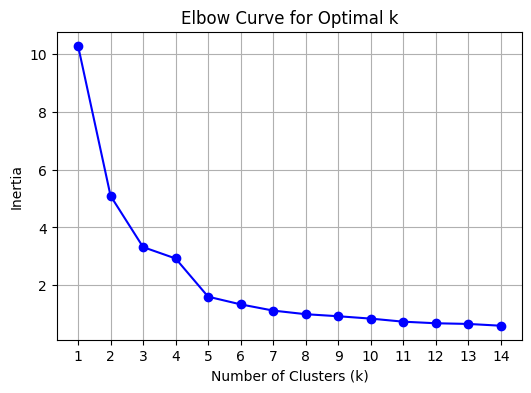

In [14]:
# Define the range of k values to test
k_values = range(1, 15)  
inertia_values = []

# Calculate inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Create the plot using an ax object
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
ax.set_title('Elbow Curve for Optimal k')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_xticks(k_values)
ax.grid(True)

In [79]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X = shap_scores_summary_df[columns_for_clustering]
shap_scores_summary_df["kmeans_cluster"] = kmeans.fit_predict(X)

# reorder the clustering based on the mean value in the cluster
kmeans_order = (
    shap_scores_summary_df.groupby("kmeans_cluster")[f"{vars_dv}_shap"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list()
)
kmeans_reorder_dict = dict(zip(kmeans_order, range(len(shap_scores_summary_df))))
shap_scores_summary_df["kmeans_cluster"] = shap_scores_summary_df["kmeans_cluster"].map(
    kmeans_reorder_dict
)

# save shap value summary
shap_scores_summary_df.to_csv(
    os.path.join(PY_FILE_LOC, "data", f"shap_values_summary_{vars_dv}.csv"), index=False
)
shap_scores_summary_df.head(3)

,pref,muni,demand,land_avail,taxable_income,LV,SPR,pv_out,PV_R,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,pref_en,muni_en,kmeans_cluster
0,北海道,函館市,1181835.0,7161.9990,316463049.0,47153.0,0.104499,1285.006554,0.059764,0.021084,-0.000960,0.008639,-0.003646,0.002336,-0.016323,0.069666,Hokkaido,Hakodate-shi,8
1,北海道,小樽市,671998.0,6629.7161,126725644.0,24344.0,0.104499,1306.230557,0.017013,-0.026412,-0.007508,0.021224,-0.003738,0.001693,-0.016321,0.027474,Hokkaido,Otaru-shi,8
2,北海道,旭川市,1505444.0,15984.9802,422951388.0,26647.0,0.104499,1242.370221,0.074342,0.037985,-0.054664,0.046388,-0.004459,0.001967,-0.003681,0.082073,Hokkaido,Asahikawa-shi,7


In [80]:
# ============================================================================ #
# Random Forest Classifier
# ============================================================================ #

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
X = shap_scores_summary_df[vars_iv]  # Features
y = shap_scores_summary_df["kmeans_cluster"]  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# save the model
model_loc = os.path.join(PY_FILE_LOC, "data", f'model_RFC_{vars_dv}_{year}.joblib')
joblib.dump(rf_clf, model_loc, compress=3)

Accuracy: 0.93


['/home/matthew/GitHub/japan-data/notebook/eds-jp-pv-growth-resi-small/data/model_RFC_PV_R_2023.joblib']

## Plots

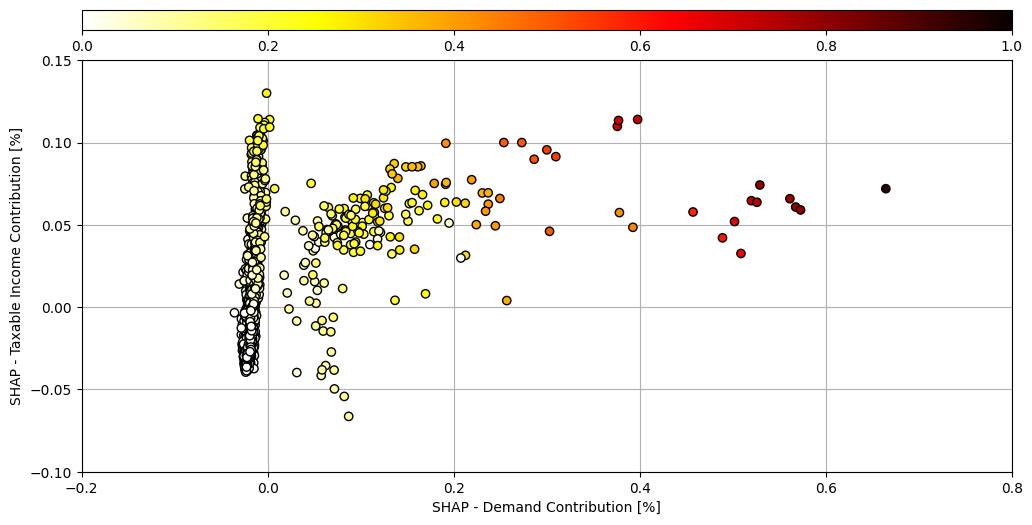

In [81]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

# Create the scatter plot
scatter = ax.scatter(
    x=shap_scores_summary_df["demand_score"],
    y=shap_scores_summary_df[f"{shap_var2}_score"],
    c=shap_scores_summary_df[f"{vars_dv}_shap"],
    cmap="hot_r",
    edgecolor="k",
    vmax=1,
)

# Add color bar
# Create a new axis for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.3)

# Create the colorbar in the new axis
cbar = plt.colorbar(scatter, cax=cax, label=None, orientation='horizontal')
# cbar.set_ticks(np.arange(len(unique_clusters)))


ax.grid(which="both", axis="both", zorder=0)
ax.set_axisbelow(True)
ylim = {"PV_R": (-0.1, 0.15), "PV_S": (-0.15, 0.20), "PV_M": (-0.1, 0.4)}
xlim = {"PV_R": (-0.2, .8), "PV_S": (-0.10, 0.35), "PV_M": (-0.15, 0.25)}
ax.set_ylim(*ylim[vars_dv])
ax.set_xlim(*xlim[vars_dv])
shap_var2_label = " ".join(shap_var2.split("_")).title()
ax.set_ylabel(f"SHAP - {shap_var2_label} Contribution [%]")
ax.set_xlabel("SHAP - Demand Contribution [%]")

savefig(fig, f'shap_{vars_dv}_solar_cap.svg')

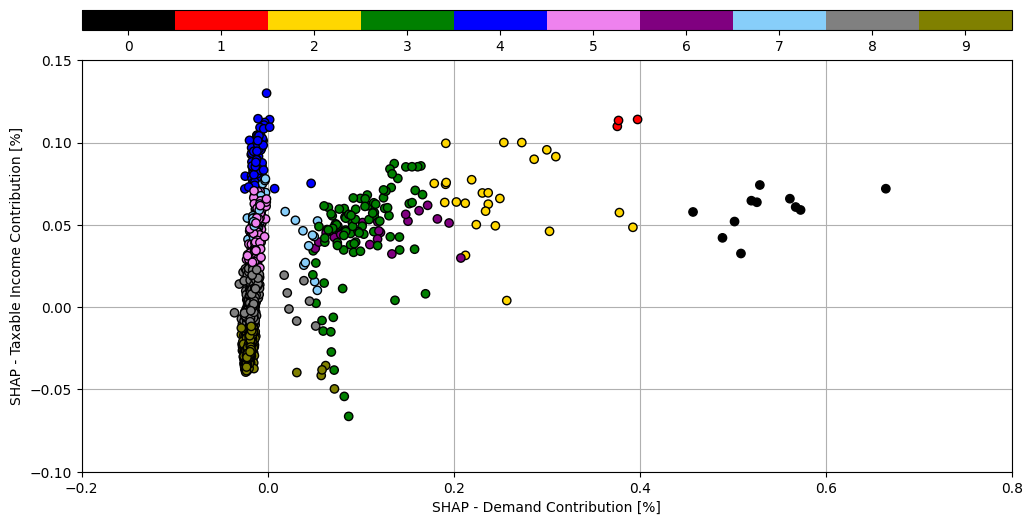

In [82]:
def plot_clusters(ax, df, x_col, y_col, cluster_col, title, colors):
    k = len(shap_scores_summary_df["kmeans_cluster"].unique())
    # Handle NaN values for DBSCAN by assigning a specific value (e.g., -1)
    cluster_values = df[cluster_col].fillna(-1)
    unique_clusters = np.unique(cluster_values)

    # Create a custom color map from the list of colors
    cmap = ListedColormap(colors[: len(unique_clusters)])
    scatter = ax.scatter(
        df[x_col], df[y_col], c=cluster_values, cmap=cmap, marker="o", edgecolor="k"
    )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)

    # Create a new axis for the colorbar
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    cax = divider.append_axes("top", size="5%", pad=0.3)


    # Create the colorbar in the new axis
    ratio = (k-1)/k
    ticks = [c*ratio + ratio/2 for c in range(k)]
    cbar = plt.colorbar(scatter, cax=cax, label=None, orientation='horizontal')
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(range(k))


colors = [
    "k",
    "red",
    "gold",
    "green",
    "blue",
    "violet",
    "purple",
    "lightskyblue",
    "gray",
    "olive",
    "orange",
    "cyan",
]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

plot_clusters(
    ax,
    shap_scores_summary_df,
    "demand_score",
    f"{shap_var2}_score",
    "kmeans_cluster",
    None,
    colors=colors,
)
ax.grid(which="both", axis="both", zorder=0)
ax.set_axisbelow(True)

ax.set_ylim(*ylim[vars_dv])
ax.set_xlim(*xlim[vars_dv])

shap_var2_label = " ".join(shap_var2.split("_")).title()
ax.set_ylabel(f"SHAP - {shap_var2_label} Contribution [%]")
ax.set_xlabel("SHAP - Demand Contribution [%]")
savefig(fig, f'shap_{vars_dv}_cluster.svg')


## Cluster Statistics

In [83]:
# gather the index of the clusters
cluster_index = dict()
for kmean_no, df_g in shap_scores_summary_df.groupby("kmeans_cluster"):
    cluster_index[kmean_no] = df_g[ftr_pref_muni].apply(tuple, axis=1).to_list()

cols_params = f"""
demand_score,4,4
land_avail_score,4,4
taxable_income_score,4,4
LV_score,5,4
SPR_score,5,4
pv_out_score,5,4
{vars_dv}_shap,2,4
{vars_dv},2,4
"""
cols_params = cols_params.strip().split("\n")
cols_params = [c.split(',') for c in cols_params]

score_stats = dict()
for cluster_no, df_cluster in shap_scores_summary_df.groupby("kmeans_cluster"):
	stat_temp = []
	for col, mean_sno, std_sno in cols_params:
		stat_temp.append(format_mean_std(
			df_cluster, col, mean_sno=int(mean_sno), std_sno=int(std_sno), std_per=True
		))
	score_stats[cluster_no] = stat_temp

score_stats = pd.DataFrame(score_stats).T
score_stats.columns = [c[0] for c in cols_params]
score_stats = score_stats.apply(align_spacing, axis=0)
score_stats.columns = [c.replace("_score", "") for c in score_stats.columns]
score_stats = score_stats.rename(columns=vars_iv_rename_cols)
print('SHAP Value Statistics:')
display(score_stats)

df_year = df[df["year"] == year]
scale_param_temp = scale_param.copy()
scale_param_temp.loc[vars_dv] = {'unit': '%',
 'scaler': 1,
 'unit_scaled': '%',
 'mean_sno': 2,
 'std_sno': 2}

print('Actual Statistics:')
display(get_cluster_actual_stats(df_year, cluster_index, scale_param_temp, std_per=True).apply(align_spacing, axis=0).rename(columns=vars_iv_rename_cols))

SHAP Value Statistics:


,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT,PV_R_shap,PV_R
0,0.5364 ± 10.3%,0.0462 ± 69.9%,0.0586 ± 21.2%,0.02432 ± 50.6%,0.00754 ±122.0%,0.00299 ±498.3%,0.73 ± 14.7%,0.75 ± 17.8%
1,0.3837 ± 3.2%,0.1299 ± 3.6%,0.1124 ± 2.0%,0.01591 ± 27.7%,0.00422 ± 28.4%,0.00295 ±223.7%,0.71 ± 1.3%,0.71 ± 2.0%
2,0.2482 ± 22.4%,0.0240 ±155.8%,0.0673 ± 33.7%,0.00605 ±160.3%,0.00426 ± 70.4%,0.00118 ±822.0%,0.41 ± 18.1%,0.42 ± 19.1%
3,0.0994 ± 31.8%,0.0092 ±240.2%,0.0451 ± 63.9%,0.00128 ±578.1%,0.00195 ±107.7%,0.00100 ±950.0%,0.22 ± 29.6%,0.22 ± 31.5%
4,-0.0099 ± 89.9%,0.0143 ± 84.6%,0.0923 ± 13.3%,0.00129 ±232.6%,0.00276 ±115.9%,0.00096 ±781.2%,0.16 ± 20.3%,0.16 ± 24.3%
5,-0.0124 ± 32.3%,0.0012 ±616.7%,0.0442 ± 27.1%,0.00131 ±206.1%,0.00282 ±170.2%,0.00098 ±704.1%,0.10 ± 24.1%,0.10 ± 26.6%
6,0.1214 ± 39.3%,-0.1060 ± 39.8%,0.0462 ± 18.6%,-0.02485 ±133.2%,0.00082 ±109.8%,-0.00341 ±167.2%,0.09 ± 84.8%,0.09 ± 86.1%
7,-0.0038 ±513.2%,-0.0352 ± 35.2%,0.0480 ± 32.5%,-0.00242 ±173.6%,0.00067 ±268.7%,-0.00286 ±143.4%,0.06 ± 38.5%,0.06 ± 41.3%
8,-0.0163 ± 47.9%,-0.0023 ±260.9%,0.0045 ±208.9%,0.00026 ±884.6%,0.00253 ±162.1%,-0.00141 ±468.1%,0.05 ± 38.6%,0.04 ± 54.2%
9,-0.0202 ± 32.2%,-0.0036 ±116.7%,-0.0265 ± 25.7%,0.00044 ±272.7%,0.00191 ±130.9%,-0.00028 ±892.9%,0.01 ±105.0%,0.01 ±107.0%


Actual Statistics:


,DEMAND,LANDAV,TAXIN,LANDVL,PVOUT,PENERT,PV_R
0,6916 ± 52.0%,14075 ± 26.1%,2329 ±90.4%,122 ± 50.0%,1266 ±4.7%,12.21 ±31.2%,0.75 ± 17.3%
1,3058 ± 19.8%,14499 ± 6.9%,756 ±11.6%,72 ± 20.8%,1306 ±5.5%,15.60 ± 8.1%,0.71 ± 1.4%
2,2712 ± 40.6%,9767 ± 50.9%,796 ±74.7%,94 ±104.3%,1260 ±4.8%,11.07 ±25.5%,0.42 ± 19.0%
3,1417 ± 21.7%,5688 ± 60.9%,370 ±69.5%,89 ± 88.8%,1284 ±5.4%,10.58 ±29.4%,0.22 ± 31.8%
4,701 ± 21.7%,5120 ± 85.4%,198 ±35.4%,73 ± 94.5%,1277 ±5.2%,10.91 ±29.0%,0.16 ± 25.0%
5,488 ± 34.4%,3917 ± 96.4%,100 ±24.0%,52 ± 84.6%,1280 ±5.2%,10.76 ±30.0%,0.10 ± 30.0%
6,2606 ± 35.4%,1378 ± 60.3%,1015 ±42.5%,362 ± 25.1%,1213 ±4.4%,9.08 ±11.9%,0.09 ± 88.9%
7,620 ± 60.3%,1975 ±227.5%,232 ±61.6%,217 ± 59.0%,1237 ±4.9%,9.26 ±25.1%,0.06 ± 33.3%
8,283 ± 62.5%,3757 ± 87.2%,50 ±46.0%,38 ±102.6%,1276 ±5.3%,11.52 ±30.8%,0.04 ± 50.0%
9,80 ±142.5%,2561 ± 98.1%,11 ±90.9%,21 ±223.8%,1280 ±5.5%,11.91 ±27.0%,0.01 ±100.0%


## Listings

In [84]:
df_year = df[df["year"] == year]
df_year[df_year[ftr_pref_muni].apply(tuple, axis=1).isin(cluster_index[0])]

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
15621,2023,宮城県,仙台市,6095535.0,18556.7470,1.897922e+09,1189.722432,111725.0,0.136080,0.803730,0.224911,0.211012,0.779324,0.562814
15872,2023,埼玉県,さいたま市,5539904.0,10196.7974,2.785429e+09,1194.255793,182968.0,0.092304,0.721825,0.241819,0.097216,0.034073,0.229365
16050,2023,神奈川県,横浜市,16791763.0,17081.3800,8.272120e+09,1191.758872,218565.0,0.092304,1.057002,0.194716,0.135176,0.055834,0.297546
16345,2023,愛知県,豊田市,3919071.0,16981.3461,8.419151e+08,1347.284741,75674.0,0.118176,0.721738,0.305700,0.345465,0.363701,0.416500
16436,2023,京都府,京都市,7906563.0,11190.5843,2.417508e+09,1267.371424,195460.0,0.063887,0.587539,0.166596,0.106868,0.162006,0.238176
16462,2023,大阪府,堺市,6209073.0,7046.1191,1.307170e+09,1328.208993,152620.0,0.063887,0.577234,0.174256,0.150980,0.071713,0.207573
16674,2023,広島県,広島市,6198512.0,18377.7043,2.097462e+09,1301.427963,99212.0,0.142264,0.674384,0.416592,0.348294,0.123147,0.336838
16811,2023,福岡県,北九州市,6970201.0,15641.8725,1.359366e+09,1264.298251,83667.0,0.158550,0.783474,0.251572,0.288776,0.576002,0.493666
16812,2023,福岡県,福岡市,8300434.0,12165.7621,2.813187e+09,1245.678456,144187.0,0.158550,0.811828,0.206261,0.135102,0.045941,0.248485
16911,2023,熊本県,熊本市,3811645.0,13655.2327,1.114968e+09,1248.479972,29800.0,0.158550,0.843921,0.578471,0.361258,0.091365,0.399158


In [85]:
get_pref_muni_isin(df_year, cluster_index[1])

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
16679,2023,広島県,福山市,3727332.0,14796.8144,692130912.0,1303.810577,55665.0,0.142264,0.713248,0.617040,0.447659,0.087486,0.394305
16757,2023,愛媛県,松山市,2552930.0,13381.3605,719783097.0,1379.392168,72793.0,0.167082,0.713350,0.328359,0.224731,0.199488,0.335629
16997,2023,鹿児島県,鹿児島市,2893505.0,15318.4497,855918658.0,1235.418461,86478.0,0.158550,0.688915,0.342988,0.217489,0.365699,0.401468


In [86]:
get_pref_muni_isin(df_year, cluster_index[2])

,year,pref,muni,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A
15715,2023,福島県,福島市,1726329.0,16280.426500,4.206918e+08,1176.123855,42976.0,0.136080,0.406566,0.190252,0.152175,0.565442,0.380477
15717,2023,福島県,郡山市,1959215.0,15921.002300,4.923922e+08,1171.459101,46297.0,0.136080,0.378227,0.215029,0.286858,0.142211,0.227607
15718,2023,福島県,いわき市,2701459.0,20942.153900,4.615277e+08,1265.687853,33918.0,0.136080,0.469095,0.594160,0.287372,0.585311,0.521218
15789,2023,茨城県,つくば市,2335923.0,8350.412700,5.164384e+08,1210.513443,55013.0,0.092304,0.457486,0.468522,0.672777,0.378624,0.459466
15840,2023,群馬県,高崎市,2532086.0,12464.928900,6.165369e+08,1258.439596,45974.0,0.092304,0.542635,0.776241,0.582845,0.528188,0.600798
15875,2023,埼玉県,川口市,2638118.0,2678.493200,1.132140e+09,1190.208160,116840.0,0.092304,0.317890,0.073727,0.023497,0.000000,0.083880
15935,2023,千葉県,千葉市,4996651.0,9786.878300,1.896750e+09,1239.349446,114852.0,0.092304,0.472700,0.391581,0.455592,0.132936,0.310932
15938,2023,千葉県,船橋市,2967540.0,3155.639800,1.256096e+09,1210.860292,148638.0,0.092304,0.353973,0.064706,0.075039,0.026075,0.106895
15949,2023,千葉県,柏市,1976333.0,4332.829900,8.209561e+08,1210.860292,119519.0,0.092304,0.343008,0.104193,0.137880,0.048830,0.133099
15951,2023,千葉県,市原市,3053540.0,11994.181000,4.506449e+08,1239.349446,47179.0,0.092304,0.284218,0.353948,0.330708,0.707540,0.481647


In [87]:
def list_cluster(cluster_no):
    merged_list = ["pref_en", "muni_en", *shap_score_cols, f"{vars_dv}_shap", vars_dv]
    return (
        shap_scores_summary_df[shap_scores_summary_df["kmeans_cluster"] == cluster_no]
        .sort_values(vars_dv, ascending=False)
        .sort_values(f"{vars_dv}_shap", ascending=False)[merged_list]
        .reset_index(drop=True)
    )
list_cluster(0)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Kanagawa,Yokohama-shi,0.664725,0.074850,0.071969,0.052578,0.006021,0.026310,0.954989,1.057002
1,Fukuoka,Fukuoka-shi,0.573036,0.054245,0.059058,0.022362,0.014898,0.017398,0.799533,0.811828
2,Miyagi,Sendai-shi,0.567776,0.063863,0.060835,0.017868,0.006034,0.019033,0.793943,0.803730
3,Kumamoto,Kumamoto-shi,0.529250,0.078173,0.074220,0.021303,0.020438,0.007283,0.789201,0.843921
4,Fukuoka,Kitakyushu-shi,0.561545,0.065323,0.065897,0.009081,0.011105,0.012906,0.784392,0.783474
5,Oita,Oita-shi,0.526060,0.068266,0.063739,0.019571,0.007564,-0.009743,0.733993,0.693117
6,Aichi,Toyota-shi,0.520117,0.066446,0.064691,0.018273,0.001161,-0.007455,0.721769,0.721738
7,Saitama,Saitama-shi,0.502042,0.006791,0.052017,0.037431,0.016621,0.002249,0.675687,0.721825
8,Hiroshima,Hiroshima-shi,0.508934,0.038431,0.032600,0.012484,0.013853,-0.022353,0.642485,0.674384
9,Kyoto,Kyoto-shi,0.489072,0.006555,0.042110,0.024918,-0.009195,-0.009383,0.602612,0.587539


In [88]:
list_cluster(1)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Hiroshima,Fukuyama-shi,0.397795,0.124537,0.114044,0.018892,0.002833,-0.001237,0.715401,0.713248
1,Ehime,Matsuyama-shi,0.375977,0.131618,0.109851,0.017947,0.004930,0.010571,0.709430,0.713350
2,Kagoshima,Kagoshima-shi,0.377288,0.133423,0.113423,0.010897,0.004894,-0.000497,0.697964,0.688915


In [89]:
list_cluster(2)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Kagawa,Takamatsu-shi,0.300183,0.053685,0.095588,0.013861,0.008428,0.015562,0.545842,0.562601
1,Gunma,Takasaki-shi,0.309852,0.057551,0.091454,0.007984,0.003697,0.010404,0.539477,0.542635
2,Aichi,Toyohashi-shi,0.286565,0.048284,0.089861,0.003734,0.007224,0.018155,0.512359,0.524711
3,Nagano,Nagano-shi,0.273265,0.062510,0.100013,0.005564,0.002983,0.000351,0.503222,0.548416
4,Gifu,Gifu-shi,0.253964,0.044891,0.100038,0.023658,0.004176,0.009629,0.494893,0.520549
5,Fukushima,Iwaki-shi,0.303107,0.069876,0.046091,0.007111,0.006437,0.001116,0.492274,0.469095
6,Wakayama,Wakayama-shi,0.249704,0.045638,0.066037,0.012948,0.000667,0.015225,0.448756,0.459355
7,Mie,Yokkaichi-shi,0.392754,-0.057065,0.048521,-0.007512,0.008216,-0.006350,0.437100,0.435062
8,Fukuoka,Kurume-shi,0.191580,0.053484,0.099559,0.011587,0.005760,0.004207,0.424713,0.459394
9,Chiba,Chiba-shi,0.378236,-0.073483,0.057458,-0.008340,0.007220,-0.000615,0.419012,0.472700


In [90]:
list_cluster(3)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Nagano,Matsumoto-shi,0.139989,0.049857,0.078227,0.010371,0.001885,0.032091,0.370956,0.393064
1,Kochi,Kochi-shi,0.155212,0.039150,0.085315,0.000108,0.003011,0.013198,0.354530,0.335013
2,Aichi,Kasugai-shi,0.161334,0.030812,0.085304,0.003502,0.004063,0.005510,0.349060,0.357437
3,Saitama,Kawagoe-shi,0.164781,0.041002,0.085816,-0.007001,0.002140,-0.001719,0.343554,0.346535
4,Hyogo,Kakogawa-shi,0.133847,0.035677,0.080998,0.001485,0.000105,0.027242,0.337889,0.342199
5,Ibaraki,Mito-shi,0.136087,0.034101,0.087215,0.003217,0.004436,0.004155,0.327746,0.369650
6,Nara,Nara-shi,0.148586,0.028090,0.085219,-0.001950,-0.001778,0.000908,0.317611,0.314599
7,Tokyo,Machida-shi,0.131501,0.034938,0.083940,-0.000237,0.000424,0.002147,0.311249,0.312659
8,Aichi,Nishio-shi,0.157998,0.033291,0.035206,0.005680,0.004339,0.015246,0.310296,0.319367
9,Yamaguchi,Yamaguchi-shi,0.128952,0.033841,0.060405,0.018039,0.005057,0.005160,0.309990,0.315903


In [91]:
list_cluster(4)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Shizuoka,Fujieda-shi,-0.001144,0.039899,0.130009,0.002802,0.003374,0.031001,0.264476,0.258417
1,Nagasaki,Omura-shi,0.002177,0.034254,0.109376,0.002988,0.010571,0.004995,0.222897,0.225970
2,Ehime,Imabari-shi,-0.010341,0.026862,0.114492,0.002751,0.004261,0.022247,0.218808,0.224407
3,Saitama,Fukaya-shi,0.002152,0.034233,0.113936,0.001740,0.001782,-0.001529,0.210850,0.210898
4,Yamaguchi,Hofu-shi,-0.004161,0.033504,0.108378,0.003070,0.007503,0.001386,0.208215,0.216412
5,Nagano,Iida-shi,-0.011497,0.030657,0.104509,0.004732,0.002501,0.017984,0.207421,0.202918
6,Nagano,Azumino-shi,-0.011600,0.031017,0.104203,0.004380,0.002072,0.016798,0.205404,0.201198
7,Saga,Karatsu-shi,-0.004790,0.023983,0.098403,0.007454,0.009165,0.011949,0.204701,0.186408
8,Hiroshima,Onomichi-shi,0.046731,0.022177,0.075215,-0.001929,0.003441,0.000317,0.204487,0.199462
9,Miyazaki,Nobeoka-shi,-0.010618,0.027255,0.101171,0.005570,0.008830,0.006178,0.196922,0.189824


In [92]:
list_cluster(5)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Kumamoto,Koshi-shi,-0.001485,0.006821,0.063858,0.003729,0.018908,0.014278,0.164645,0.175773
1,Kagoshima,Aira-shi,-0.007935,0.013123,0.061684,0.002437,0.020759,0.015917,0.164519,0.167055
2,Oita,Nakatsu-shi,-0.001260,0.012309,0.065708,0.005711,0.014406,0.008793,0.164202,0.162185
3,Kumamoto,Tamana-shi,-0.009458,0.012120,0.053618,0.003250,0.015390,0.014029,0.147485,0.144780
4,Saga,Tosu-shi,-0.001634,0.007436,0.061338,0.000083,0.013377,0.006352,0.145488,0.140774
5,Yamanashi,Minamialps-shi,-0.007649,0.009282,0.059981,0.002805,-0.000016,0.021364,0.144303,0.159491
6,Iwate,Ichinoseki-shi,-0.003195,0.005698,0.064175,-0.000510,0.006214,0.010163,0.141081,0.131812
7,Kyoto,Kizugawa-shi,-0.006725,0.012344,0.063068,0.005158,0.001354,0.003155,0.136889,0.145801
8,Kumamoto,Amakusa-shi,-0.011695,0.007603,0.054234,0.002421,0.011525,0.013416,0.136039,0.124311
9,Shiga,Omihachiman-shi,-0.004787,0.008557,0.064717,0.003227,-0.000643,0.006405,0.136012,0.139187


In [93]:
list_cluster(6)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Tokyo,Nerima-ku,0.172045,-0.045347,0.061869,-0.016085,0.000759,0.010067,0.241844,0.248795
1,Tokyo,Adachi-ku,0.182513,-0.047723,0.053604,-0.018499,0.001095,0.004040,0.233565,0.223559
2,Osaka,Higashiosaka-shi,0.162813,-0.081087,0.058590,-0.001238,-0.001184,0.002008,0.198438,0.205690
3,Hyogo,Amagasaki-shi,0.148467,-0.081295,0.056385,-0.011429,-0.000913,-0.001188,0.168563,0.168296
4,Tokyo,Ota-ku,0.150912,-0.059306,0.052232,-0.029554,0.000268,-0.010438,0.162650,0.162122
5,Aichi,Tokai-shi,0.133595,-0.083139,0.032337,0.008780,0.001045,0.008482,0.159636,0.159334
6,Tokyo,Edogawa-ku,0.118472,-0.057529,0.051741,-0.029817,0.000961,-0.008890,0.133474,0.129990
7,Tokyo,Itabashi-ku,0.102048,-0.092037,0.051393,-0.014944,0.000521,-0.004448,0.101068,0.098729
8,Tokyo,Meguro-ku,0.066775,-0.088236,0.046459,-0.012802,0.000616,-0.007040,0.064307,0.066809
9,Tokyo,Kita-ku,0.062891,-0.089338,0.045227,-0.014590,0.000560,-0.007615,0.055671,0.056379


In [94]:
list_cluster(7)

,pref_en,muni_en,demand_score,land_avail_score,taxable_income_score,LV_score,SPR_score,pv_out_score,PV_R_shap,PV_R
0,Aichi,Ama-shi,-0.007259,-0.016983,0.067690,0.007468,0.003108,0.006362,0.118922,0.125214
1,Hyogo,Itami-shi,0.048251,-0.039976,0.043739,0.005011,0.000100,0.000067,0.115727,0.118821
2,Osaka,Neyagawa-shi,-0.002416,-0.023336,0.077966,0.001656,-0.001068,0.003215,0.114553,0.122190
3,Kanagawa,Ebina-shi,-0.002870,-0.023778,0.076931,0.003818,0.000652,-0.003676,0.109613,0.113291
4,Aichi,Owariasahi-shi,-0.008562,-0.022317,0.065343,0.006832,0.002788,0.005855,0.108475,0.110707
5,Saitama,Misato-shi,0.018883,-0.023487,0.058051,0.000874,0.000882,-0.009177,0.104562,0.101761
6,Fukuoka,Onojo-shi,-0.008434,-0.025150,0.062680,0.005959,0.004655,0.002667,0.100911,0.100057
7,Aichi,Kitanagoya-shi,-0.007974,-0.025267,0.060880,0.006519,0.002861,0.004809,0.100363,0.108595
8,Aichi,Chiryu-shi,-0.009944,-0.029568,0.059461,0.002945,0.002320,0.014492,0.098242,0.099900
9,Tokyo,Fuchu-shi,0.053642,-0.049488,0.052347,-0.010311,0.000484,-0.009410,0.095800,0.100308
